# Find wet vegetation (daily masking)

- Use wofs to mask daily imagery
- Calculate TCG and TCW
- Find daily wet vegetation
- Summarise monthly wet vegetation

### Import

In [1]:
import sys
import datacube
from datacube.helpers import write_geotiff
from datacube.utils import cog
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datacube.storage import masking

sys.path.append("Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map
from dea_bandindices import calculate_indices
from dea_datahandling import wofs_fuser
from dea_dask import create_local_dask_cluster

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:45095 Dashboard: /user/gabrielleh/proxy/8787/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


In [3]:
dc = datacube.Datacube(app="Sentinel_2_burn_ratio")

### Get coordinates from tile
- Too big to load many images

In [4]:
tile = '11_-40'
# Define funciton to get tile bounds
def get_tile_bounds(tile):
    x, y = tile.split('_')
    minx = int(x) * 100000
    miny = int(y) * 100000
    maxx = minx + 100000
    maxy = miny + 100000
    return {'minx': minx, 'miny': miny, 'maxx': maxx, 'maxy': maxy}
bounds = get_tile_bounds(tile)
x=(bounds['minx'],bounds['maxx'])
y=(bounds['miny'],bounds['maxy'])

### Use coordinates to locate small area of interest

In [13]:
# Set the central latitude and longitude
# #Barmah
# central_lat = -35.858473
# central_lon = 145.023703


# #GKP
# central_lat = -35.847129
# central_lon = 144.386452

# Barren Grounds
# central_lat = -34.709078
# central_lon = 150.715434

# # Mac Marshes
# central_lat = -30.698510
# central_lon = 147.534219

# # # Yorke
# central_lat = -34.211294
# central_lon =  137.774868

# # Arafura
# central_lat = -12.562990
# central_lon =  135.035205

# # Ayr
central_lat = -19.371645
central_lon =  146.922991

# # Burdekin
# central_lat = -19.926378 
# central_lon =  145.626075

# # Tas
# central_lat = -42.019291
# central_lon =  146.214005

# Syd
# central_lat = -34.558100
# central_lon =  150.646049


# Set the buffer to load around the central coordinates
buffer = 0.5

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, crs='EPSG:4326', margin=-0.2)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

### Load WOFLS

In [14]:
# # Create a reusable query
# query = {
#     "x": study_area_lon,
#     "y": study_area_lat,
#     "time": ('2016-01-01', '2016-12-31'),
#     "output_crs": "EPSG:3577",
#     "crs":'EPSG:4326',
#     "resolution": (-25, 25),
#     "group_by": "solar_day",
#     "fuse_func": wofs_fuser,
# }


# # Load the data from the datacube
# wofls = dc.load(product="wofs_albers", 
#                 dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
#                 **query)


In [15]:
# wofls

In [16]:
# Plot the loaded WOFLs
# wofls.water.plot(col="time", col_wrap=5)
# plt.show()

### Load surface reflectance

In [17]:
# list(dc.list_products()['name'])

In [18]:
# Load a fractional cover (FC) tile to match the WOFLs data by using 'like'
# data = dc.load(product="ga_ls8c_ard_3", group_by="solar_day", 
#                measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
#                dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
#                like=wofls)

# Create a reusable query
query = {
    "x": study_area_lon,
    "y": study_area_lat,
    "time": ('2016-01-01', '2016-12-31'),
    "output_crs": "EPSG:3577",
    "crs":'EPSG:4326',
    "resolution": (-30, 30),
#     "group_by": "solar_day",
#     "fuse_func": wofs_fuser,
}


data = load_ard(dc=dc,
                min_gooddata=0.1,
                products=["ga_ls8c_ard_3"], 
                group_by="solar_day", 
                measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
                dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
                **query)
# data

Scripts/dea_datahandling.py:209: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can significantly slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Loading ga_ls8c_ard_3 data
    Filtering to 39 out of 46 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 39 observations as a dask array


In [20]:
list(dc.list_products()['name'])

['camden_insar_alos_displacement',
 'fc_percentile_albers_annual',
 'fc_percentile_albers_seasonal',
 'ga_ls5t_ard_3',
 'ga_ls7e_ard_3',
 'ga_ls8c_ard_3',
 'ga_s2a_ard_nbar_granule',
 'ga_s2am_fractional_cover_2',
 'ga_s2b_ard_nbar_granule',
 'ga_s2bm_fractional_cover_2',
 'high_tide_comp_20p',
 'item_v2',
 'item_v2_conf',
 'landsat_barest_earth',
 'low_tide_comp_20p',
 'ls5_ard',
 'ls5_fc_albers',
 'ls5_level1_usgs',
 'ls5_nbart_geomedian_annual',
 'ls5_nbart_tmad_annual',
 'ls5_pq_albers',
 'ls5_usgs_l2c1',
 'ls7_ard',
 'ls7_fc_albers',
 'ls7_level1_usgs',
 'ls7_nbart_geomedian_annual',
 'ls7_nbart_tmad_annual',
 'ls7_pq_albers',
 'ls7_usgs_l2c1',
 'ls8_ard',
 'ls8_barest_earth_albers',
 'ls8_fc_albers',
 'ls8_level1_usgs',
 'ls8_nbart_geomedian_annual',
 'ls8_nbart_tmad_annual',
 'ls8_pq_albers',
 'ls8_usgs_l2c1',
 'mangrove_cover',
 'multi_scale_topographic_position',
 'nidem',
 's1_gamma0_geotif_scene',
 's2a_ard_granule',
 's2a_l1c_aws_pds',
 's2a_level1c_granule',
 's2a_nrt_gran

In [21]:
mang = dc.load(product='mangrove_cover',**query)

In [11]:
data

,Array,Chunk
Bytes,2.00 GB,36.00 MB
Shape,"(34, 4091, 3591)","(1, 3000, 3000)"
Count,2970 Tasks,136 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.00 GB,36.00 MB
Shape,"(34, 4091, 3591)","(1, 3000, 3000)"
Count,2970 Tasks,136 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


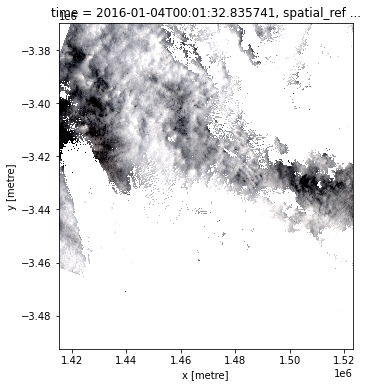

In [57]:
# data.nbart_red.plot(col="time", col_wrap=5)
# plt.show()

rgb(data.isel(time=0))

### Make cloud mask

In [58]:
# # Make cloud free data
# def cloud_free(data,wofls):
#     # Remove milliseconds 
#     data['time'] = data.indexes['time'].normalize()
#     wofls['time'] = wofls.indexes['time'].normalize()

#     # Find duplicates
#     wofls_dates = wofls['time'].isin(data['time'].values)

#     # Only select NRT that is not duplicated in ARD
#     wofls_sel = wofls.sel(time=wofls_dates)
#     # wofls_sel

#     # Removing clouds and their shadows
#     clear = {"cloud_shadow": False, "cloud": False, "nodata":False, "noncontiguous": False}

#     cloudfree = masking.make_mask(wofls_sel, **clear)
#     cloudfree_data = data.where(cloudfree.water == True)
#     # cloudfree_data.nbart_red.plot()
#     # plt.show()
#     return cloudfree_data

In [59]:
# cloudfree_data = cloud_free(data,wofls)

### Calculate TCG and TCW

In [60]:
cloudfree_data = data

In [61]:
cloudfree_data = calculate_indices( cloudfree_data, 
                          index='TCW', 
                          collection='ga_ls_3', 
                          normalise=False,
                          drop=False)

cloudfree_data = calculate_indices( cloudfree_data, 
                          index='TCG', 
                          collection='ga_ls_3', 
                          normalise=False,
                          drop=False)

Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCW') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "
Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCG') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


In [62]:
# (cloudfree_data.TCG>1000).plot(col="time", cmap='Greens',col_wrap=5)
# plt.show()

In [63]:
# (cloudfree_data.TCW>-350).plot(col="time", cmap='Blues',col_wrap=5)
# plt.show()

### Calculate daily wet vegetation

In [71]:
tcg_thres = 1000
tcw_thres = -600

green = cloudfree_data.TCG > tcg_thres
wet = cloudfree_data.TCW > tcw_thres
not_green= wet.where(green != 1,0,0)

not_green = not_green.groupby('time.month').max(dim='time')  
# not_green = np.where(green.TCG != 1, wet.TCW, 0)
# not_green = (green.TCG != 1) & wet.TCW #green.TCG & wet.TCW
not_green

<xarray.DataArray 'TCW' (month: 12, y: 4091, x: 3591)>
dask.array<stack, shape=(12, 4091, 3591), dtype=int64, chunksize=(1, 3000, 3000), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 1.415e+06 1.415e+06 ... 1.523e+06 1.523e+06
  * y            (y) float64 -3.37e+06 -3.37e+06 ... -3.492e+06 -3.492e+06
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [72]:
# not_green.plot(col="month", cmap='Blues',col_wrap=5)
# plt.show()

### Plot image
- Save out image

In [73]:
# not_green.plot.imshow(col="month", cmap='Blues', col_wrap=4, size=4,interpolation='gaussian')
# fig = not_green.plot(col="month", cmap='Blues', col_wrap=4, size=4)
# plt.savefig('foo.png')

### Annual statistics

In [74]:
freq = not_green.sum(dim='month')
# freq.plot.imshow(cmap='Blues',interpolation='gaussian')

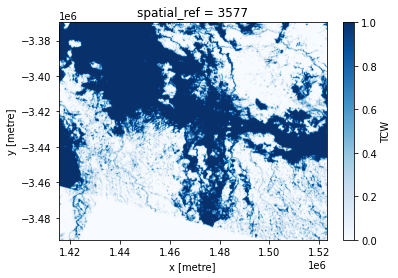

In [75]:
year_max = (freq >= 1)
year_max.plot.imshow(cmap='Blues',interpolation='gaussian')

In [76]:
# year_max.astype('int8')

In [77]:
cog.write_cog(freq.astype('int8'),f'freq_mac_marsh_TCG_{tcg_thres}_TCW_{tcw_thres}.tif').compute()
cog.write_cog(year_max.astype('int8'),f'max_mac_marsh_TCG_{tcg_thres}_TCW_{tcw_thres}.tif').compute()

PosixPath('max_mac_marsh_TCG_1000_TCW_-600.tif')

In [ ]:
pwd

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [24]:
import copy
from itertools import groupby

In [25]:
### Consecutive count
def consecutive_count(water_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of water (1) for each pixel across the time series

    :param numpy.array water_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for water (1) and not water (0)
    :param float required_consecutive: how many consectutive 1's to be classified as water?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is water (1)     
    '''

    for y in range(water_numpy.shape[1]):
        for x in range(water_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = water_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive water classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy


In [26]:
# Calculate TCW
data = calculate_indices(data,
                        index='TCW', 
                        collection='ga_ls_3',
                        drop=False,
                        normalise=False)

# Calculate TCW
data = calculate_indices(data,
                        index='TCG', 
                        collection='ga_ls_3',
                        drop=False,
                        normalise=False)

# Set thresholds
tcg_thres = 1000
tcw_thres = -600

# Apply thresholds
green = data.TCG > tcg_thres
wet = (data.TCW > tcw_thres) & (data.TCW < 0) # wet but not open water
wet_veg = wet.where(green != 1,0,0)

# Calculate monthly maximum
wet_veg_month = wet_veg.groupby('time.month').max(dim='time')  

# Calculate annual frequency
wet_veg_freq = wet_veg_month.sum(dim='month')

# Calculate annual maximum extent
# Require that wet vegetation was detected more than once
wet_veg_max = (wet_veg_freq > 1)

# # Make empty monthly array
# watersea = copy.deepcopy(wet_veg_max)
# watersea.values = np.zeros_like(wet_veg_max, dtype='float64')
# print('watersea',watersea)


Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCW') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "
Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCG') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


watersea <xarray.DataArray 'TCW' (y: 4091, x: 3591)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    spatial_ref  int32 3577
  * y            (y) float64 -3.37e+06 -3.37e+06 ... -3.492e+06 -3.492e+06
  * x            (x) float64 1.415e+06 1.415e+06 ... 1.523e+06 1.523e+06


In [27]:
# # Get ready for consecutive count
# wet_numpy = wet_veg_month.values
# empty_numpy = watersea.values

# # Required consecutive
# required_consecutive = 1

# # Calculate consecutive counts
# consec = consecutive_count(wet_numpy, empty_numpy, required_consecutive)

# # Create new data array with sampe dimensions as original
# wet_summary = xr.DataArray(consec, coords=wet_veg_max.coords, dims=wet_veg_max.dims)

# print(wet_summary)

<xarray.DataArray (y: 4091, x: 3591)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    spatial_ref  int32 3577
  * y            (y) float64 -3.37e+06 -3.37e+06 ... -3.492e+06 -3.492e+06
  * x            (x) float64 1.415e+06 1.415e+06 ... 1.523e+06 1.523e+06


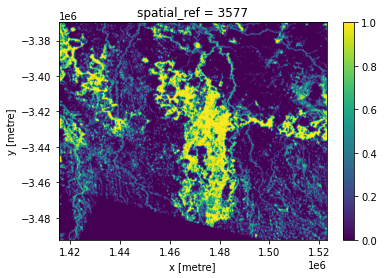

In [31]:
wet_summary.plot.imshow(interpolation="gaussian")

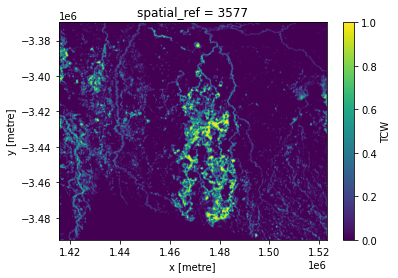

In [32]:
wet_veg_max.plot.imshow(interpolation="gaussian")